## util.py

In [1]:
%%writefile ./util.py
import urllib.request
from tqdm import tqdm

def downloadByURL(url, output_path):
    """
    HTTP 파일 다운로드
    """
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)
        
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)
        
def oneHotEncoding(label, classNum):
    """
    라벨링된 int를 oneHot 인코딩한다
    ex) oneHotEncoding(0, 2) -> [1, 0]
    ex) oneHotEncoding(1, 2) -> [0, 1]
    """
    oneHot = [0]*classNum
    oneHot[label] = 1
    return oneHot

Overwriting ./util.py


## analysis.py

In [2]:
%%writefile ./analysis.py
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

class Analysis():
     
    def __init__(self, data):
        """
        전체 분석
        """
        self.countAnalysis(data)
        print()
        self.textAnalysis(data)
        print()
        self.showWordCloud(data.text)
        
    def countAnalysis(self, data):
        """
        데이터 수량 조사
        """
        
        labeled_data = data.loc[data.label != -1]
        total_count = len(data) # 전체 데이터 수
        labeled_count = len(labeled_data) # 라벨링 된 데이터 수

        print('> 데이터 수량 조사')
        print(f'전체 데이터 수: {total_count}개')
        print(f'라벨링된 데이터 수: {labeled_count}개')
        for label, count in data.label.value_counts().iteritems():
            print(f'class {label} : {count}개')
    
    def textAnalysis(self, data):
        """
        text 길이 분석
        """
        text_len = data.text.apply(len)
        plt.figure(figsize=(12, 5))
        plt.hist(text_len, bins=200, alpha=0.5, color= 'r', label='length of text')
        plt.legend(fontsize='x-large')
        plt.yscale('log', nonposy='clip')
        plt.title('Log-Histogram of length of text')
        plt.xlabel('Length of text')
        plt.ylabel('Number of text')

        print('> 문장 길이 분석')
        print('문장 길이 최대 값: {}'.format(np.max(text_len)))
        print('문장 길이 최소 값: {}'.format(np.min(text_len)))
        print('문장 길이 평균 값: {:.2f}'.format(np.mean(text_len)))
        print('문장 길이 표준편차: {:.2f}'.format(np.std(text_len)))
        print('문장 길이 중간 값: {}'.format(np.median(text_len)))

        # 사분위의 대한 경우는 0~100 스케일로 되어있음
        print('문장 길이 제 1 사분위: {}'.format(np.percentile(text_len, 25)))
        print('문장 길이 제 3 사분위: {}'.format(np.percentile(text_len, 75)))
            
    def showWordCloud(self, text):
        """
        WordCloud
        """
        # 한글 폰트 깨짐방지
        for font in ["/Library/Fonts/NanumGothic.ttf", "/Library/Fonts/NotoSansCJKkr-Light.otf"]:
            if os.path.isfile(font):
                FONT_PATH = font
                break
        cloud = WordCloud(font_path=FONT_PATH).generate(" ".join(text))
        plt.figure(figsize=(20, 15))
        plt.imshow(cloud)
        plt.axis('off')

Overwriting ./analysis.py


## document.py
- [awesome-devblog : feeds](https://awesome-devblog.now.sh/api/korean/people/feeds)

In [3]:
%%writefile ./document.py
import os, re, csv, requests, json
import numpy as np
import pandas as pd
from enum import Enum
from tqdm import trange
from bs4 import BeautifulSoup

class KEYS(Enum):
    # -1 : 아직 라벨링 안함 (default)
    # 0  : 개발과 관련없는 문서
    # 1  : 개발과 관련있는 문서
    LABEL = 'label'
    
    # TAGS + TITLE + DESC
    TEXT = 'text'
    
    # DATA_URL 결과 파싱용 Keys(Beans)
    ID = '_id'
    TITLE = 'title'
    DESC = 'description'
    TAGS = 'tags'
    LINK = 'link'
    
    def getDocKeys():
        return [KEYS.ID.value, KEYS.TITLE.value, KEYS.DESC.value, KEYS.TAGS.value, KEYS.LINK.value]
    
    def getTitleBlackList():
        return ['', 'about']
    
    def getTextKeys():
        return [KEYS.TAGS.value, KEYS.TITLE.value, KEYS.DESC.value]

class Document():
    
    def __init__(self, update=False):
        
        # Constant
        self.DATA_URL = 'https://awesome-devblog.now.sh/api/korean/people/feeds'
        self.DOCUMENTS_PATH = './data/documents.csv'
        self.MAX_REQ_SIZE = 5000
        
        # 기본 폴더 생성
        for path in ['./data', './model', './wv_model']:
            if not os.path.isdir(path):
                os.makedirs(path)
        
        if update:
            self.updateDocs()
        
    def _getTotal(self):
        """
        전체 문서 개수 요청
        """
        res = requests.get(self.DATA_URL, { 'size': 1 })
        res.raise_for_status()
        doc = res.json()
        return doc['total'][0]['count']

    def _reqDoc(self, page, size, preprocessing=False):
        """
        문서 요청
        - page는 0 부터 시작
        - 전처리(self._preprocessing) 후 반환
        """
        page += 1
        params = {
            'sort': 'date.asc',
            'page': page,
            'size': size
        }
        res = requests.get(self.DATA_URL, params)
        res.raise_for_status()
        doc = res.json()
        
        # json to dataframe
        doc = pd.DataFrame(doc['data'], columns=KEYS.getDocKeys())
        
        # add label
        doc.insert(0, KEYS.LABEL.value, -1)
        
        if preprocessing:
            return self._preprocessing(doc)
        else:
            return doc
    
    def _preprocessing(self, doc, joinTags=True):
        """
        문서 전처리
        - KEYS 이외의 key 삭제
        - [tag] list join to string
        - [title / description / tags] 영어, 한글, 공백 이외의 것들 모두 삭제
        - html tag 삭제
        - \n, \r 삭제
        - 2번 이상의 공백 1개로 통합
        - 영어 대문자 소문자로 변환
        - 앞뒤 공백 삭제
        - text 컬럼 생성 : text = tags + title + description
        """
        
        # title, description, tags
        def textPreprocessing(x):
            x = BeautifulSoup(str(x), "html.parser").get_text()
            x = re.sub('[^가-힣a-zA-Z\s]', '', x)
            return x
        
        # all
        def docPreprocessing(x):
            x = re.sub('[\n\r]', '', x)
            x = re.sub('\s{2,}', ' ', x)
            x = x.lower()
            x = x.strip()
            return x
        
        for key in doc.columns:
            if joinTags and KEYS(key) == KEYS.TAGS:
                doc[key] = doc[key].apply(lambda x: ' '.join(x))
            if key in KEYS.getTextKeys():
                doc[key] = doc[key].apply(textPreprocessing)
                
            if key in KEYS.getDocKeys():
                doc[key] = doc[key].apply(docPreprocessing)
            
        # remove blacklist
        doc = doc.drop(doc[doc[KEYS.TITLE.value].isin(KEYS.getTitleBlackList())].index).reset_index()
                        
        # create text column
        join_with = lambda x: ' '.join(x.dropna().astype(str))
        doc[KEYS.TEXT.value] = doc[KEYS.getTextKeys()].apply(
            join_with,
            axis=1
        )
        return doc
        

    def _reqDocs(self, size, start_page=0):
        """
        전체 문서 요청
        """
        total = self._getTotal()
        if size > self.MAX_REQ_SIZE: size = self.MAX_REQ_SIZE
        total_req = round(total/size + 0.5)
        docs = pd.DataFrame()
        for i in trange(start_page, total_req):
            doc = self._reqDoc(i, size)
            if docs.empty:
                docs = doc
            else:
                docs = docs.append(doc)
        return self._preprocessing(docs)
    
    def getDocs(self, labeled_only=True):
        """
        전체 문서 조회
        labeled
        :True = 라벨링 된 데이터만 가져오기
        :False = 전체 데이터 가져오기
        """
        if not os.path.isfile(self.DOCUMENTS_PATH):
            print('> 문서가 없으므로 서버에 요청합니다.')
            self.updateDocs()
        data = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',', dtype={KEYS.LABEL.value: np.int64})
        if not labeled_only:
            return data
        else:
            return data.loc[data.label != -1]
    
    def updateDocs(self):
        """
        최신 문서 추가
        - 데이터가 없는 경우, 전체 데이터를 가져옴
        - 기존 데이터가 있는 경우, 없는 데이터만 추가
        """
        size = self.MAX_REQ_SIZE
        
        if not os.path.isfile(self.DOCUMENTS_PATH):
            # 데이터가 없는 경우
            docs = self._reqDocs(size)
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        else:
            # 기존 데이터가 있는 경우
            num_new_docs = 0
            docs = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
            total = self._getTotal()
            total_docs = len(docs)
            new_docs_num = total - total_docs
            new_docs = self._reqDocs(size, total_docs // size)
            
            # _id가 기존 데이터에 존재하지 않는 경우에만 추가
            docs = docs.append(new_docs[~new_docs[KEYS.ID.value].isin(docs[KEYS.ID.value])])
            docs.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
            
            if total_docs == len(docs):
                print('> 문서가 최신 상태입니다.')
            else:
                print(f'> 신규 문서 {len(docs) - total_docs}개 추가')
    
    def syncDocLabel(self, old_document_path, sep, override=False):
        """
        기존 라벨링한 데이터를 신규 문서에 반영
        - title, link 기준으로 일치하는 문서 검색
        """
        
        document = pd.read_csv(self.DOCUMENTS_PATH, delimiter=',')
        old_document = pd.read_csv(old_document_path, delimiter=sep)
        self._preprocessing(old_document, joinTags=False)
        for index, row in old_document.iterrows():
            link = row.link
            title = row.title
            label = int(row.label)
            if not len(document.loc[document.title.str.strip() == title.strip()]) and not len(document.loc[document.link == link]):
                print(f'not found : {row.title}')
            elif len(document.loc[document.title.str.strip() == title.strip()]):
                document.loc[document.title.str.strip() == title.strip(), KEYS.LABEL.value] = label
            elif len(document.loc[document.link == link]):
                document.loc[document.link == link, KEYS.LABEL.value] = label
        
        # save synchronized document
        if override:
            document.to_csv(self.DOCUMENTS_PATH, sep=",", index=False)
        print('done')

Overwriting ./document.py


## word_vector.py
- [FastText wiki 한국어 데이터](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz)

In [4]:
%%writefile ./word_vector.py
import os
import numpy as np
from util import downloadByURL
from gensim.models import FastText, fasttext # 둘이 다름 주의!

"""
FastText base word embedding
"""
class WordVector():
    
    def __init__(self):
        # corpus
        self.WIKI_KO_DATA = './data/cc.ko.300.bin.gz'
        self.WIKI_KO_DATA_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz'

        # pretrained model
        self.WIKI_KO_MODEL_PATH = f'./wv_model/ko.wiki'

    def getCustomModel(self, text, size=4, window=3, min_count=1, epochs=10):
        """
        FastText 기반 모델 학습
        """
        model = FastText(size=size, window=window, min_count=min_count)
        model.build_vocab(sentences=text)
        model.train(sentences=text, total_examples=len(text), epochs=epochs)
        return model
    
    def getWikiModel(self):
        """
        위키 한국어 데이터 기반 모델 학습
        """
        model = None
        if not os.path.isfile(self.WIKI_KO_MODEL_PATH):
            print('학습된 모델이 없습니다.')
            
            if not os.path.isfile(self.WIKI_KO_DATA):
                print('모델 학습에 필요한 데이터를 다운로드를 시작합니다.')
                downloadByURL(self.WIKI_KO_DATA_URL, self.WIKI_KO_DATA)
            
            print('모델 학습을 시작합니다.')
            model = fasttext.load_facebook_model(self.WIKI_KO_DATA)
            model.save(self.WIKI_KO_MODEL_PATH)
            
        else:
            model = FastText.load(self.WIKI_KO_MODEL_PATH)
        
        print(f'vocab size : {len(model.wv.vocab)}')
        return model
    
    def getSimilarWords(self, wv_model, word, topn=5):
        """
        유사단어 조회
        """
        return wv_model.wv.similar_by_word(word, topn)
    
    def vectorization(self, wv_model, text, embedding_dim=300):
        """
        주어진 문장을 단어별로 벡터화한 뒤 평균값을 문장의 벡터로 반환
        embedding_dim : wv_model vector의 차원 수 (wiki 기반 fasttext는 300차원)
        """
        words = text.split(' ')
        words_num = len(words)
        
        # model dimension (wiki festtext의 경우 300)
        vector = np.zeros(embedding_dim)
        for word in words:
            vector += wv_model[word]
        return vector/words_num


Overwriting ./word_vector.py


In [ ]:
classifier 자리

## main.py

In [6]:
from util import oneHotEncoding
from document import Document
from analysis import Analysis
from word_vector import WordVector

In [7]:
doc = Document()
data = doc.getDocs(True) # 라벨링 된 데이터만 가져오기
data.sample(3)

,index,label,_id,title,description,tags,link,text
20262,930,0,5ce297feebd32e00044c8437,팀 아슬하다 아슬 주니어 진행 상황,지난주 토요일월 일 야술 주니어를 마무리와 책 집필 정리를 위해 우리 사무실에 모였...,NaN,https://blog.naver.com/chandong83/221542310503,팀 아슬하다 아슬 주니어 진행 상황 지난주 토요일월 일 야술 주니어를 마무리와 책...
25697,1534,1,5d79622480e7b50004ca554f,piano lesson,어제 일이 끝나는 대로 딸아이 피아노 레슨하는 곳으로 달려 갔다 앉아서 기다리고 있...,NaN,http://www.namooz.com/2019/09/11/piano-lesson/,piano lesson 어제 일이 끝나는 대로 딸아이 피아노 레슨하는 곳으로 달려...
22582,3306,1,5d270f5e76c1c200044fc68b,til,수 today i learned 알고리즘 문제 풀이 우주전쟁 알고리즘 멘토링 해주시...,algorithm,https://sdong001.github.io/today_i_learned/201...,algorithm til 수 today i learned 알고리즘 문제 풀이 우주전...


> 데이터 수량 조사
전체 데이터 수: 34620개
라벨링된 데이터 수: 10382개
class -1 : 24238개
class 1 : 7634개
class 0 : 2748개

> 문장 길이 분석
문장 길이 최대 값: 358
문장 길이 최소 값: 3
문장 길이 평균 값: 145.02
문장 길이 표준편차: 60.59
문장 길이 중간 값: 132.0
문장 길이 제 1 사분위: 108.0
문장 길이 제 3 사분위: 203.0



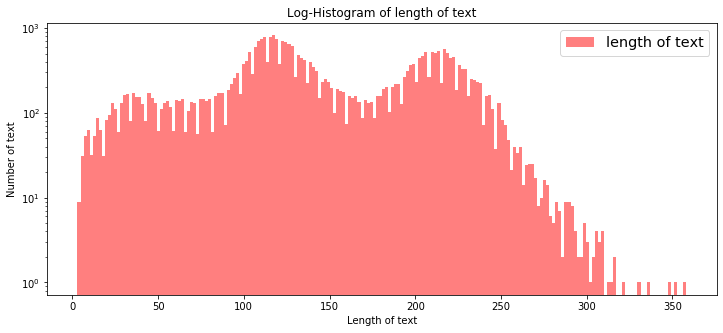

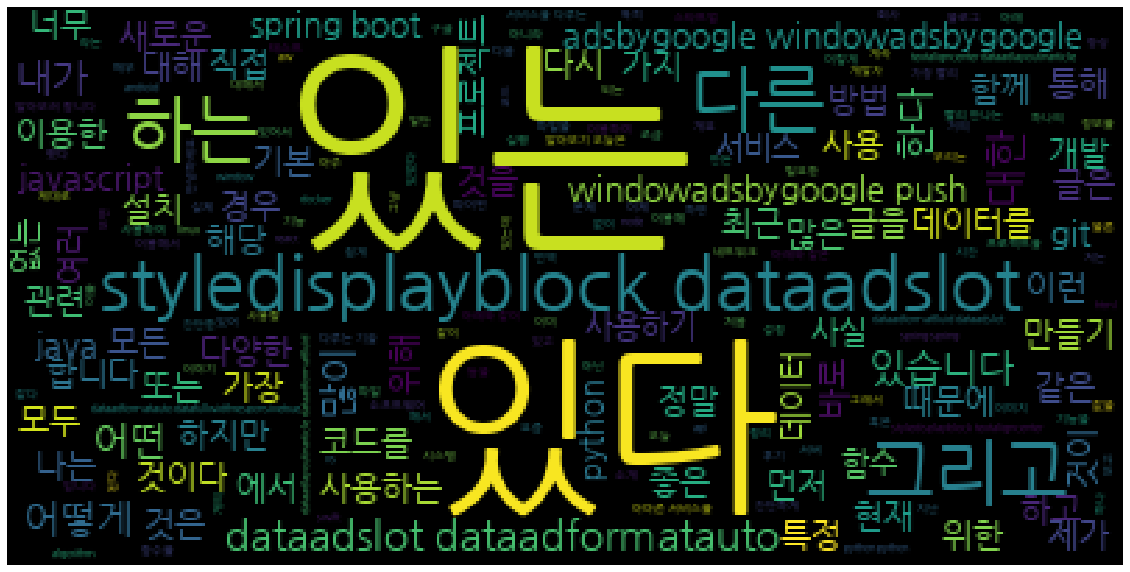

In [8]:
Analysis(doc.getDocs(labeled_only=False)) # 전체 데이터에 대해서 분석

In [9]:
data.label = data.label.apply(lambda x: oneHotEncoding(x, 2)) # one hot encoding
data.sample(3)

,index,label,_id,title,description,tags,link,text
25366,1195,"[0, 1]",5d72bc746055880004025fe0,의미론적 마크업에서 태그는 금기인가,의미론적 마크업이 새로운 패러다임이 되면서 퍼진 몇 가지 왜곡된 사실이 있습니다 그...,NaN,http://dev.epiloum.net/770,의미론적 마크업에서 태그는 금기인가 의미론적 마크업이 새로운 패러다임이 되면서 퍼...
29018,4938,"[0, 1]",5dc87c18c65fd3000467bfbe,python skill python input output 함수 알아보기,파이썬엔 여러 입출력 관련 함수가 있습니다 가장 대표적인게 input print와 ...,python,https://potensj.tistory.com/120,python python skill python input output 함수 알아보...
23020,3754,"[0, 1]",5d30f03799e8e1000448f12f,개발자들의 마음을 아프게하는 상황들 그리고 가슴에 비수를 던지는 말을 너무 쉽게 한다,슬프게도 비개발자들 조직 내에 있는 개발자들에게 그런 말이나 그런 상황이 너무 쉽게...,NaN,https://brunch.co.kr/@@19f4/578,개발자들의 마음을 아프게하는 상황들 그리고 가슴에 비수를 던지는 말을 너무 쉽게 ...


In [10]:
wv = WordVector()
wv_model = wv.getWikiModel()

vocab size : 2000000


In [11]:
wv.getSimilarWords(wv_model, '파이썬', 5)

[('Python', 0.565061628818512),
 ('자이썬', 0.5624369382858276),
 ('레일스', 0.5598082542419434),
 ('파이썬을', 0.5595801472663879),
 ('언어용', 0.5288202166557312)]

In [11]:
data.text = data.text.apply(lambda x: wv.vectorization(wv_model, x, 300))
data.sample(3)

,index,label,_id,title,description,tags,link,text
18413,4001,"[0, 1]",5cb182f1b726c50004d0f83f,spring boot gradle plugin 스프링 부트 그래이들 플러그인,필자가 이번주 업무 중에 lombok 을 사용하는 프로젝트에서 jar 패키징 실패가...,spring boot spring,https://brunch.co.kr/@@2mri/186,"[-0.02387598584199705, -0.014304683958603577, ..."
26762,2632,"[0, 1]",5d91aaa590fdba00042ef7ea,django tweetme 소셜서비스 구현해보기 django setup,안녕하세요 개발자 울이입니다 이번 포스팅 부터는 django를 활용해서 tweetm...,django,https://woolbro.tistory.com/55,"[-0.011306137996999657, -0.009551657714730348,..."
25040,860,"[1, 0]",5d6a1cff7f6f5400049f8cad,book 린 인,book 린 인 셰릴 샌드버그 지음 안기순 옮김 자기 분야에서 정상에 오르기 위해 ...,NaN,https://jaewook.blog/2019/08/30/book-%eb%a6%b0...,"[-0.031095130627509206, 0.02179337543435395, 0..."


## classifier.py

In [5]:
# %%writefile ./classifier.py
class Classifier():
    
    def __init__(self):
        return
        
    def train(self):
        return
    
    def predict(self):
        return